done simulate data 27.349513053894043
done compute mu map and mu in length interval 4.0531158447265625e-05
done null simulation 26.405161142349243
len fretimes 424153
len mufreqs 424153
4.41498589515686
BIC:  3051.062134658746
all done
all done 0 0.035002946853637695
done simulate data 31.18270182609558
done compute mu map and mu in length interval 5.14984130859375e-05
done null simulation 29.46294331550598
len fretimes 423929
len mufreqs 423929
4.592710971832275
BIC:  3804.6511485855413
all done
all done 1 0.02566051483154297
done simulate data 28.02685832977295
done compute mu map and mu in length interval 2.6226043701171875e-05
done null simulation 28.395209074020386
len fretimes 424104
len mufreqs 424104
4.851467609405518
BIC:  3616.6352542894247
all done
all done 2 0.008717060089111328
done simulate data 31.82836675643921
done compute mu map and mu in length interval 3.170967102050781e-05
done null simulation 28.773275136947632
len fretimes 422066
len mufreqs 422066
4.931959867477

/tmp/ipykernel_1054/2053179085.py:648: RuntimeWarning: divide by zero encountered in log
  plt.plot(investlist[i],numpy.log(Ntlist[i])/numpy.log(10) )
/tmp/ipykernel_1054/2053179085.py:648: RuntimeWarning: divide by zero encountered in log
  plt.plot(investlist[i],numpy.log(Ntlist[i])/numpy.log(10) )
/tmp/ipykernel_1054/2053179085.py:648: RuntimeWarning: divide by zero encountered in log
  plt.plot(investlist[i],numpy.log(Ntlist[i])/numpy.log(10) )
/tmp/ipykernel_1054/2053179085.py:648: RuntimeWarning: divide by zero encountered in log
  plt.plot(investlist[i],numpy.log(Ntlist[i])/numpy.log(10) )
/tmp/ipykernel_1054/2053179085.py:648: RuntimeWarning: divide by zero encountered in log
  plt.plot(investlist[i],numpy.log(Ntlist[i])/numpy.log(10) )


(3.0, 7.0)

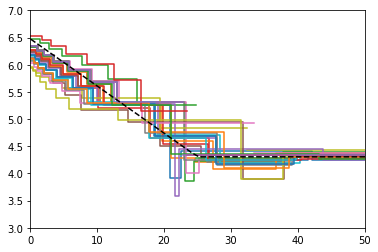

In [3]:
import statistics
import msprime
from IPython.display import SVG, display
import tsinfer
import scipy
import math
import numpy
import tskit
import io
import builtins
import sys
from tqdm.notebook import tqdm
from tskit import MISSING_DATA
import pickle
import random
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.linear_model import LassoLarsIC
from sklearn.linear_model import LassoLarsIC
import matplotlib.pyplot as plt
import cvxopt as opt
from cvxopt import matrix, spmatrix, sparse
from cvxopt.solvers import qp, options
from cvxopt import blas
from cvxopt import spdiag
import statsmodels
from statsmodels.nonparametric.kernel_regression import KernelReg
from scipy.signal import savgol_filter
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
import time




import bisect
def find_s(elem, sorted_list):
    'Locate the leftmost value exactly equal to x'
    i = bisect.bisect_left(sorted_list, elem)
    if i != len(sorted_list) and sorted_list[i] == elem:
        return i


def find_s_se(elem, sorted_list):
    'Locate the leftmost value smaller or equal to x'
    i = bisect.bisect_right(sorted_list, elem)
    if i != 0:
        return i-1
    else:
        print("error")


def find_s_s(elem, sorted_list):
    'Locate the leftmost value smaller or equal to x'
    i = bisect.bisect_left(sorted_list, elem)
    if i != 0:
        return i
    else:
        return 0
    
def est_mu_map_fun(mu_ave,site_pos_sort,est_mu_map_num_inter,seq_len):
    inter = numpy.linspace(0,seq_len,est_mu_map_num_inter+1)
    cur_num_l = 0
    num_mu_int = numpy.zeros(len(inter)-1)
    for k in range(1,len(inter)):
        cur_num_r = find_s_s(inter[k], site_pos_sort )
        num_mu_int[k-1] = cur_num_r-cur_num_l
        cur_num_l = cur_num_r
    est_mu_rate = num_mu_int/( inter[1:] - inter[0: (len(inter)-1)]   )   
    est_mu_rate = est_mu_rate/sum(est_mu_rate)*mu_ave*est_mu_map_num_inter
    return([inter,est_mu_rate])

seq_len = 10**8
sam_size = 1000

pop_size_con = 10000
r_con = 10**(-8)

########
mu_map_unknown = 0
mu_ave = 1.3*10**(-8)
est_mu_map_num_inter = 1
##########


c_value = 0.65*10**(-1)
c1=0

totaliter=25

numtildet = 100


########################## Demographic model #########################################


pop_ini_size = 1500000
demo_model = msprime.Demography.isolated_model([pop_ini_size], growth_rate=[0.2])
demo_model.add_population_parameters_change(25,  initial_size=None, growth_rate=0, population=None)


############################## r map ######################################

r_map = 10**(-8)


############################ mu map         ###################################
################################################################################
mu_map = 1.3*10**(-8)



################################################################################




lamd = []
Ntlist = []
investlist = []


sum_time = 0
for it in range(totaliter):

    
    s_time_sim_data = time.time()
    
####### observe #########
    ts1 = msprime.sim_ancestry(
        samples=sam_size,
        recombination_rate= r_map, 
        sequence_length= seq_len,
#         population_size = pop_size,
#         gene_conversion_rate = gene_conver ,
#         gene_conversion_tract_length = track_len,
#         random_seed = it*10+1,
#         discrete_genome=False,
        demography = demo_model
        )
    # Visualise the simulated ancestral history.
    #SVG(ts.draw_svg())

    #ts.num_trees


    mts1 = msprime.sim_mutations(ts1, rate = mu_map,
                                discrete_genome=False,
#                                 random_seed= it*10+1
                               )

    #print(iter,"done generating")

    
    e_time_sim_data = time.time()
    print('done simulate data', e_time_sim_data-s_time_sim_data)
    
    s_time = time.time()
    
    if mu_map_unknown == 1:
        site_pos_sort = mts1.tables.sites.position
        aa = est_mu_map_fun(mu_ave,site_pos_sort,est_mu_map_num_inter,seq_len)
        mu_map = msprime.RateMap(position=aa[0].tolist(), rate=aa[1].tolist())

    

    if isinstance(mu_map, float) ==1:
        seq_bp = [*range(0,seq_len, int(c_value/mu_map) )]
        seq_bp.append(seq_len)
        seq_bp=numpy.array(seq_bp)
    else:
        seq_bp = [0]
        current_seq_site = 0
        need_cum_rate = c_value
        for i in range(len(mu_map.right)):
            current_mu_change_point = mu_map.right[i]
            current_mu_map_rate = mu_map.rate[i]
            while need_cum_rate/current_mu_map_rate <= (current_mu_change_point - current_seq_site):
                seq_bp.append(current_seq_site + need_cum_rate/current_mu_map_rate)
                current_seq_site = seq_bp[-1]
                need_cum_rate = c_value
            need_cum_rate = need_cum_rate - (current_mu_change_point - current_seq_site)*current_mu_map_rate
            current_seq_site = current_mu_change_point
        if seq_bp[-1] != seq_len:
            seq_bp.append(seq_len)
        seq_bp = numpy.array(seq_bp)


                  ###### Compute the weighted average mu of each interval ###########
    mu_in_interval = c_value / ( seq_bp[1:] - seq_bp[0:(len(seq_bp)-1)] )

    ################################################################################    
    
    e_time_mu = time.time()
    print("done compute mu map and mu in length interval", e_time_mu-s_time)

    ts = msprime.sim_ancestry(
        samples=sam_size,
        recombination_rate= r_con, 
        sequence_length= seq_len,
        population_size = pop_size_con,
#         random_seed =it*10+1026,
#         discrete_genome=False,
        #demography = demo_model
        )
    # Visualise the simulated ancestral history.
    #SVG(ts.draw_svg())

    #ts.num_trees


    mts = msprime.sim_mutations(ts, rate = mu_map,
                                discrete_genome=False,
#                                 random_seed=it*10+1026
                               )

    #print(iter,"done generating")
    
    e_time_null_sim = time.time()
    print("done null simulation", e_time_null_sim-s_time)
    
    
    
    s_time_xmat_ymat = time.time()


    #### new improvement ######################################### 

    mu_time = mts.tables.mutations.time
#     mu_site_id = mts.tables.mutations.site
#     mu_site = mts.tables.sites.position[mu_site_id]
#     mu_node = mts.tables.mutations.node
    mufreq = numpy.zeros(len(mu_time))
#     rate_nomu = numpy.zeros( (len(seq_bp)-1)*(2*sam_size-1) )
#     rate_mu = numpy.zeros( (len(seq_bp)-1)*(2*sam_size-1) )
#     timevec_all = numpy.zeros( (len(seq_bp)-1)*(2*sam_size-1) )
#     current_seq_int = 0
#     current_site = seq_bp[0]
#     current_interval_r = seq_bp[1]
#     current_rate_nomu = numpy.zeros(2*sam_size-1)
    freqtime = mu_time


    #####################################################
    ######################################################
    ######################################################
    ######################################################
    #####################################################



#     tildetcheckm1 = []
#     for i in range(1,numtildet-1):
#         tildetcheckm1.append( numpy.sort(freqtime)[int(len(freqtime)/numtildet*i)])
#     tildetcheck = tildetcheckm1 + [max(freqtime)]

    # 自己决定tildetcheck    
#     tildetcheck = [0.01,0.02,0.04,0.08,  0.16, 0.32, 0.64,  2.56,  10.24, 40.96, 163.84, 655.36, 2621.44]
    tildetcheck = [0.01,0.02,0.04,0.08,  0.16,  0.32, 1.28,  5.12,  20.48, 81.92, 327.68, 1310.72, 5242.88,20971.52]
    if tildetcheck[-1] < max(freqtime):
        tildetcheck = tildetcheck+[max(freqtime)]
        
        
#     # 自己决定tildetcheck    
#     tildetcheck = numpy.arange(0.2,2,0.2).tolist() + [10,50,250,1250,6250,31250]
#     if tildetcheck[-1] < max(freqtime):
#         tildetcheck = tildetcheck+[max(freqtime)]





    time_bp = numpy.array(tildetcheck[0:(len(tildetcheck)-1) ] )   

    mu_index = 0
    for tree in mts.trees():
        for each_mu in tree.mutations():
            mufreq[mu_index] = tree.num_samples(each_mu.node)
            mu_index = mu_index+1
        


#         ## pairs (i, i+1)
#         tree_high = numpy.zeros(2*sam_size-1)
#         for i in range(2*sam_size-1):
#             ## pairs (i, i+1)
#             tree_high[i] = 2*tree.tmrca(i,i+1)     
#         tree_lp = tree.interval[0]
#         tree_rp = tree.interval[1]


#         while tree_rp >= current_interval_r:
#             rate_nomu[ current_seq_int*(2*sam_size-1) : (current_seq_int+1)*(2*sam_size-1) ] = current_rate_nomu + \
#                                                                     tree_high*(current_interval_r - current_site)
#             timevec_all[ current_seq_int*(2*sam_size-1) : (current_seq_int+1)*(2*sam_size-1) ] = \
#                 rate_nomu[ current_seq_int*(2*sam_size-1) : (current_seq_int+1)*(2*sam_size-1) ]\
#                 /(seq_bp[current_seq_int+1] - seq_bp[current_seq_int] )/2
#             if isinstance(mu_map, float) ==1 :
#                 rate_mu[ current_seq_int*(2*sam_size-1) : (current_seq_int+1)*(2*sam_size-1) ] = \
#                 rate_nomu[ current_seq_int*(2*sam_size-1) :(current_seq_int+1)*(2*sam_size-1) ]*mu_map
#             else:
#                 rate_mu[ current_seq_int*(2*sam_size-1) : (current_seq_int+1)*(2*sam_size-1) ] = \
#                 rate_nomu[ current_seq_int*(2*sam_size-1) :(current_seq_int+1)*(2*sam_size-1) ]*mu_in_interval[current_seq_int]
#             current_site = current_interval_r
#             current_rate_nomu = numpy.zeros(2*sam_size-1)
#             if current_site != seq_bp[-1]:
#                 current_seq_int = current_seq_int+1
#                 current_interval_r = seq_bp[current_seq_int+1]
#             else:
#                 break


#         current_rate_nomu = current_rate_nomu + tree_high*(tree_rp - current_site)
#         current_site = tree_rp

#     ############################################################################ 

#     if len(mufreq) != len(freqtime):
#         print("something is wrong")
#     print("done2") 

    ############################################################################ 


    nummuwithin_obs =  mts1.allele_frequency_spectrum(polarised=True, span_normalise=False)[1:]

    #########################################################################################



    ##############################################################################################




    freqtsortbytime = numpy.transpose(sorted(numpy.transpose(numpy.array([freqtime,mufreq])).tolist()))
    freqtimes = freqtsortbytime[0]
    mufreqs = freqtsortbytime[1]

    tinterval = numpy.zeros(len(freqtimes))
    curint = 0
    tiltind = 0
    curtimett = tildetcheck[tiltind]
    print("len fretimes", len(freqtimes))
    for i in range(len(freqtimes)):
        if freqtimes[i] <= curtimett:
            tinterval[i] = curint
        else:
            tiltind = tiltind + 1
            curtimett = tildetcheck[tiltind]
            while curtimett<freqtimes[i]:
                curint = curint + 1
                tiltind = tiltind + 1
                curtimett = tildetcheck[tiltind]

            curint = curint + 1
            tinterval[i] = curint

    tinterval = tinterval.astype(int)
    ##############################################################

#     ####### new improvement ############

#     afs = numpy.zeros( (len(seq_bp)-1) *(2*sam_size-1) )
#     for i in range(2*sam_size-1):
#         current_afs_all = mts1.allele_frequency_spectrum(sample_sets = [[i,i+1]], polarised=True, \
#                                                     windows = seq_bp, span_normalise=False)
#         current_afs = current_afs_all[:,1]
#         index = i + numpy.array( [*range(len(seq_bp)-1)]) * (2*sam_size-1)
#         afs[index] = current_afs + numpy.random.poisson( ( seq_bp[1:]-seq_bp[:(len(seq_bp) -1)] )*epsilon*2 )

#     print("done2")     


#     afs_sort = numpy.sort(afs)
#     sortindex = numpy.argsort(rate_mu)
#     rate_mu_sort = rate_mu[sortindex]
#     timevec_all_sort = timevec_all[sortindex]

    #############################################################################################
    ##############################################################################################


    Xmat = numpy.zeros( (len(nummuwithin_obs),  max(tinterval)+1)   )
    Xmat = Xmat.astype("float64")

    infreqint = numpy.zeros(len(mufreqs))
    for i in range(len(mufreqs)):
        infreqint[i] =  mufreqs[i]-1 
    infreqint = infreqint.astype(int)

    lenf = len(nummuwithin_obs)
    print("len mufreqs", len(mufreqs))
    for i in range(len(mufreqs)):
        a1 = infreqint[i] 
        a2 = tinterval[i]
        if a1 < lenf:
            Xmat[a1][a2] = Xmat[a1][a2] + 1


    Ymat = numpy.array(nummuwithin_obs)
    Ymat = Ymat.astype("float64")


    ####### new improvement ############

#     ####### new improvement ############


#     Xmat_new = numpy.zeros((len(rate_mu_sort), len(time_bp)+1 )) 
#     for i in range(len(timevec_all_sort)):
#         current_time = timevec_all_sort[i]
#         current_rate = rate_mu_sort[i]
#         index = find_s_s(current_time,time_bp)
#         if index==0:
#             Xmat_new[i,index] = current_rate
#         else:
#             Xmat_new[i,0]  = current_rate * time_bp[0]/current_time
#             Xmat_new[i,1:index] = current_rate * (time_bp[1:index]-time_bp[0:(index-1)])/current_time
#             Xmat_new[i,index] = current_rate * (current_time - time_bp[index-1]) / current_time

#     #### density deconvolution
#     Ymat_obs = afs_sort        
#     yvec = numpy.arange(min(Ymat_obs) , min( min(Ymat_obs) +  len(Ymat_obs),  max(Ymat_obs)+1) )
#     den_mean = numpy.zeros(len(yvec))
#     den_obs = numpy.zeros(len(yvec))
#     for i in range(len(yvec)):
#         val = yvec[i]
#         den_obs[i] = ( find_s_s(val+1,Ymat_obs) - find_s_s(val,Ymat_obs) ) / len(Ymat_obs)
#     find_den_x_mat = numpy.zeros( (len(den_mean),len(yvec)) )
#     for i in range(len(find_den_x_mat)):
#         val = yvec[i]
#         find_den_x_mat[i] = scipy.stats.poisson.pmf(val,mu=yvec)
#     find_den_y_mat = den_obs
#     lm = LinearRegression(fit_intercept=False,positive = True)
#     lm.fit(find_den_x_mat,find_den_y_mat)    
#     den_mean = lm.coef_
#     cdf_mean = numpy.cumsum(den_mean)
#     quan_vec =  numpy.arange(1,len(Xmat_new)+1)   /(len(Xmat_new) +1 )
#     Ymat_new = numpy.zeros(len(Xmat_new))
#     for i in range(len(quan_vec)):
#         yloc = find_s_s(quan_vec[i],cdf_mean)
#         if yloc==0:
#             Ymat_new[i] = yvec[yloc ] + quan_vec[i]/(cdf_mean[yloc]  ) 
#         elif yloc == len(cdf_mean):
#             Ymat_new[i] = yvec[yloc-1] + (quan_vec[i]-cdf_mean[-1])/(1-cdf_mean[-1])
#         else:
#             Ymat_new[i] = yvec[yloc ] + (quan_vec[i] - cdf_mean[yloc-1])/(cdf_mean[yloc] - cdf_mean[yloc-1] ) 



#     #     Xmat_new = Xmat_new[0:3000]
#     #     Ymat_new = Ymat_new[0:3000]

#     ##############################################################################################





    ####### combine #############################################################

#     ####### weight Xmat_new so that it has equal importance to Xmat

#     Xmat_new = Xmat_new*numpy.sqrt( c1/len(Xmat_new) )
#     Ymat_new = Ymat_new*numpy.sqrt( c1/len(Ymat_new) )

    
#     Xmat = Xmat[1:]
#     Ymat = Ymat[1:]

#     Xmat_combine = numpy.concatenate((Xmat, Xmat_new), axis=0)
#     Ymat_combine = numpy.concatenate((Ymat, Ymat_new))
    Xmat_combine = Xmat
    Ymat_combine = Ymat

    e_time_xmat_ymat = time.time()

    print(    e_time_xmat_ymat -     s_time_xmat_ymat )

    
    
    


    s_time_reg = time.time()
    
    ## weighted least square
    Xfit = numpy.zeros( (len(Xmat_combine[:,0]),len(Xmat_combine[0,:]) ) )
    Yfit = numpy.zeros(len(Ymat_combine))
    for i in range(len(Ymat_combine)):
    #         Xfit[i,:] = Xmat_combine[i,:]/(sum(Xmat_combine[i,:])+1)
    #         Yfit[i] = Ymat_combine[i]/(sum(Xmat_combine[i,:])+1)
    #         Xfit[i,:] = Xmat_combine[i,:]/(sum(Xmat_combine[i,:])+1)/(numpy.sqrt( Ymat_combine[i]+1) / (sum(Xmat_combine[i,:])+1) )
    #         Yfit[i] = Ymat_combine[i]/(sum(Xmat_combine[i,:])+1)/ (numpy.sqrt( Ymat_combine[i]+1) / (sum(Xmat_combine[i,:])+1) )
        Xfit[i,:] = Xmat_combine[i,:]/numpy.sqrt(Ymat_combine[i]+1)
        Yfit[i] = Ymat_combine[i]/numpy.sqrt(Ymat_combine[i]+1)




    ########################### penalyse difference of slopes ######

    current_lambda = 0.01

#     PXmat = numpy.zeros((len(Xmat_combine[0])-2, len(Xmat_combine[0]) ))


#     It_list = numpy.array(tildetcheck)
#     It_list[1:] = numpy.array(tildetcheck[1:])-numpy.array(tildetcheck[0:(len(tildetcheck)-1)])

#     ### weighting beta by time gap ########################
#     for i in range(len(PXmat)):
#         if i<7:
#             PXmat[i,i] =  1/(8**(4-i))*numpy.sqrt(0.5*It_list[i] + 0.5*It_list[i+2] + It_list[i+1])*numpy.sqrt(current_lambda)*1/(0.5*(It_list[i] + It_list[i+1]) )
#             PXmat[i,i+1] = 1/(8**(4-i))*numpy.sqrt(0.5*It_list[i] + 0.5*It_list[i+2] + It_list[i+1])*numpy.sqrt(current_lambda)*(-1/(0.5*(It_list[i] + It_list[i+1]) ) - 1/(0.5*(It_list[i+1] + It_list[i+2]) ) ) 
#             PXmat[i,i+2] = 1/(8**(4-i))*numpy.sqrt(0.5*It_list[i] + 0.5*It_list[i+2] + It_list[i+1])*numpy.sqrt(current_lambda)*1/(0.5*(It_list[i+1] + It_list[i+2]) )
#         else:
#             PXmat[i,i] =  numpy.sqrt(0.5*It_list[i] + 0.5*It_list[i+2] + It_list[i+1])*numpy.sqrt(current_lambda)*1/(0.5*(It_list[i] + It_list[i+1]) )
#             PXmat[i,i+1] = numpy.sqrt(0.5*It_list[i] + 0.5*It_list[i+2] + It_list[i+1])*numpy.sqrt(current_lambda)*(-1/(0.5*(It_list[i] + It_list[i+1]) ) - 1/(0.5*(It_list[i+1] + It_list[i+2]) ) ) 
#             PXmat[i,i+2] = numpy.sqrt(0.5*It_list[i] + 0.5*It_list[i+2] + It_list[i+1])*numpy.sqrt(current_lambda)*1/(0.5*(It_list[i+1] + It_list[i+2]) )
               
#     PYmat = numpy.zeros(len(Xmat_combine[0])-2)

#     Xfit1 = numpy.concatenate((Xfit, PXmat), axis=0)
#     Yfit1 = numpy.concatenate((Yfit, PYmat), axis=0)

#     fitmodel = LinearRegression(fit_intercept=False,positive = True)

#     fitmodel.fit(Xfit1,Yfit1)    
#     sol = fitmodel.coef_

#     # correct the last term:
#     sol[-1]= 0.5*(It_list[i+1] + It_list[i+1])*(1/(0.5*(It_list[i] + It_list[i+1]) )*sol[-2] \
#                                                 + 1/(0.5*(It_list[i+1] + It_list[i+1]) )*sol[-2]\
#                                                 - 1/(0.5*(It_list[i] + It_list[i+1]) )*sol[-3]  )

    PXmat = numpy.zeros((len(Xfit[0])-2, len(Xfit[0]) ))

    It_list = numpy.array(tildetcheck)
    It_list[1:] = numpy.array(tildetcheck[1:])-numpy.array(tildetcheck[0:(len(tildetcheck)-1)])

    ### weighting beta by time gap ########################
    for i in range(len(PXmat)):
        PXmat[i,i] =  numpy.sqrt(current_lambda)*(1)
        PXmat[i,i+1] = numpy.sqrt(current_lambda)*( -2 ) 
        PXmat[i,i+2] = numpy.sqrt(current_lambda)*(1)

    PYmat = numpy.zeros(len(Xfit[0])-2)

    Xfit1 = numpy.concatenate((Xfit, PXmat), axis=0)
    Yfit1 = numpy.concatenate((Yfit, PYmat), axis=0)

    fitmodel = LinearRegression(fit_intercept=False,positive = True)

    fitmodel.fit(Xfit1,Yfit1)    
    sol = fitmodel.coef_

    # correct the last term:
    sol[-1]= 2*sol[-2] - sol[-3]  


    #############################

    rss = sum((numpy.matmul(Xfit,sol)-Yfit)**2)
    aa = numpy.matmul(numpy.transpose(Xfit1),Xfit1)
    bb= numpy.linalg.inv(aa)
    cc = numpy.matmul(Xfit,bb)
    df = sum(sum(cc*Xfit))
    bic = len(Xfit)*numpy.log(rss/len(Xfit)) + df*numpy.log(len(Xfit))
    print("BIC: ",bic)

    #############################



    tcheck = [sol[0]*tildetcheck[0] ]
    for i in range(1,len(tildetcheck)):
        tcheck.append(tcheck[i-1] + sol[i]*(tildetcheck[i] - tildetcheck[i-1] )  )

    #############################################################################

    invest = []
    invest.append(0)
    Nt = []
    for i in range(len(tcheck)-1):
        Nt.append(sol[i]*pop_size_con*2)
        Nt.append(sol[i]*pop_size_con*2)
        invest.append(tcheck[i])
        invest.append(tcheck[i])
    Nt.append(sol[-1]*pop_size_con*2)
    Nt.append(sol[-1]*pop_size_con*2)
    invest.append(tcheck[-1])


    Ntlist.append(Nt)  
    investlist.append(invest)
    print("all done")

    e_time = time.time()

    sum_time = sum_time + e_time-s_time    
    
    e_time_reg = time.time()
    
    print("all done",it, e_time_reg-s_time_reg)
    
    name = str(it)+"_Model8_Nt_approach12.dat"
    file = open(name,"wb") 
    pickle.dump(Nt,file)
    file.close()

    name = str(it)+"_Model8_invest__approach12.dat"
    file = open(name,"wb") 
    pickle.dump(invest,file)
    file.close()
    

ave_time = sum_time/totaliter
print("average time", ave_time)

name = "Model8_ave_time_approach12.dat"
file = open(name,"wb") 
pickle.dump(ave_time,file)
file.close()   

name = "Model8_Ntlist_approach12.dat"
file = open(name,"wb") 
pickle.dump(Ntlist,file)
file.close()

name = "Model8_investlist__approach12.dat"
file = open(name,"wb") 
pickle.dump(investlist,file)
file.close()

name = "Model8_lambda__approach12.dat"
file = open(name,"wb") 
pickle.dump(lamd,file)
file.close()




for i in range(len(Ntlist)):
    investlist[i][0]=0.001
    plt.plot(investlist[i],numpy.log(Ntlist[i])/numpy.log(10) )

x1 = numpy.linspace(0.1,200,200)
x2 = numpy.linspace(205,50000,500)
x = numpy.array(x1.tolist()+x2.tolist())

y = numpy.zeros(len(x))

for i in range(len(x)):
    if x[i] <= 25:
        y[i] = 1500000*2*numpy.exp(-0.2*x[i])
    else:
        y[i] = 1500000*2*numpy.exp(-0.2*25)

        
plt.plot(x,numpy.log(y)/numpy.log(10),'k--')



plt.xlim(0,50)
plt.ylim(3,7)



In [7]:
0.01,0.02,0.04,0.08,0.16,0.32,0.64,1.28, 6.4, 32,160,800

(0.02, 0.04, 0.0)

In [ ]:
 0.32, 1.28,  5.12,  20.48, 81.92, 327.68, 1310.72, 5242.88,20971.52

In [67]:
5242.88*4

20971.52

In [32]:
sol

array([64.14252338, 58.23453269, 52.2119582 , 45.85952128, 38.76402583,
       30.50052945, 19.91144792,  8.23777554,  0.        ,  1.07829368,
        1.00290406,  1.02182758,  1.04075111])

In [53]:
tcheck

[1.0786091078001612,
 3.4638044173953917,
 9.67626707257374,
 22.32915670770886,
 30.55818194718219,
 36.36755358571618,
 133.8103520045674,
 427.75043830534565,
 1601.0697172454725,
 6903.283981617376,
 26883.863374471897,
 221263.34806880116]

In [25]:
tildetcheck

[0.025,
 0.1,
 0.4,
 1.6,
 6.4,
 25.6,
 102.4,
 409,
 6,
 1638.4,
 6553.6,
 26214.4,
 251107.98701957328]

In [26]:
cumsuminv = numpy.zeros(len(y))
for i in range(len(x)-1):
    cumsuminv[i+1] = cumsuminv[i] + 1/y[i]*(x[i+1]-x[i])


t_true =[]
for i in range(len(tildetcheck)):
    ind = find_s_s(tildetcheck[i]/20000,cumsuminv)
    if ind == len(x):
        ind = ind-1
    t_true.append(x[ind])


t_true


[3.11356783919598,
 8.136180904522613,
 14.163316582914574,
 20.190452261306532,
 27.22211055276382,
 47.312562814070354,
 124.6608040201005,
 504.36873747494985,
 27.22211055276382,
 1701.8436873747494,
 6691.322645290581,
 26549.448897795588,
 50000.0]

In [ ]:
3.2    

In [ ]:
0.025 0.05 0.1 0.2 0.4 0.8 1.6 3.2 6.4 32 160 800 4000 20000 100000

In [19]:
6.4*5*5*5*5

4000.0

3162277.6601683795

/tmp/ipykernel_934/2835203446.py:97: RuntimeWarning: divide by zero encountered in log
  plt.plot(investlist[i],numpy.log(numpy.array(Ntlist[i]))/numpy.log(10))
/tmp/ipykernel_934/2835203446.py:97: RuntimeWarning: divide by zero encountered in log
  plt.plot(investlist[i],numpy.log(numpy.array(Ntlist[i]))/numpy.log(10))
/tmp/ipykernel_934/2835203446.py:97: RuntimeWarning: divide by zero encountered in log
  plt.plot(investlist[i],numpy.log(numpy.array(Ntlist[i]))/numpy.log(10))
/tmp/ipykernel_934/2835203446.py:97: RuntimeWarning: divide by zero encountered in log
  plt.plot(investlist[i],numpy.log(numpy.array(Ntlist[i]))/numpy.log(10))
/tmp/ipykernel_934/2835203446.py:97: RuntimeWarning: divide by zero encountered in log
  plt.plot(investlist[i],numpy.log(numpy.array(Ntlist[i]))/numpy.log(10))
/tmp/ipykernel_934/2835203446.py:97: RuntimeWarning: divide by zero encountered in log
  plt.plot(investlist[i],numpy.log(numpy.array(Ntlist[i]))/numpy.log(10))
/tmp/ipykernel_934/2835203446.py:9

(0.0, 50.0)

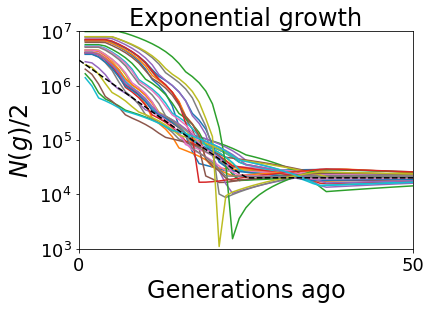

In [2]:

import statistics
import msprime
from IPython.display import SVG, display
import tsinfer
import scipy
import math
import numpy
import tskit
import io
import builtins
import sys
from tqdm.notebook import tqdm
from tskit import MISSING_DATA
import pickle
import random
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.linear_model import LassoLarsIC
from sklearn.linear_model import LassoLarsIC
import matplotlib.pyplot as plt
import cvxopt as opt
from cvxopt import matrix, spmatrix, sparse
from cvxopt.solvers import qp, options
from cvxopt import blas
from cvxopt import spdiag
import statsmodels
from statsmodels.nonparametric.kernel_regression import KernelReg
from scipy.signal import savgol_filter
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
import time
import bisect

name = "Model8_ave_time_approach12.dat"
file = open(name,"rb") 
ave_time = pickle.load(file)
file.close()   

name = "Model8_Ntlist_approach12.dat"
file = open(name,"rb") 
Ntlist = pickle.load(file)
file.close()

name = "Model8_investlist__approach12.dat"
file = open(name,"rb") 
investlist = pickle.load(file)
file.close()


def find_s_s(elem, sorted_list):
    'Locate the leftmost value smaller or equal to x'
    i = bisect.bisect_left(sorted_list, elem)
    if i != 0:
        return i
    else:
        return 0


    

allx = numpy.array( [*range(400)] )
ally = numpy.zeros( (len(Ntlist),len([*range(400)]) ) )


for i in range(len(Ntlist)):
    tpoint = [0]
    Npoint = []
    for j in range(len(investlist[i])):
        if j % 2 == 1:
            tpoint.append(investlist[i][j])
    for j in range(len(Ntlist[i])):
        if j % 2 == 1:
            Npoint.append(Ntlist[i][j])

    pxpoint = [0] 
    pypoint = [Npoint[0]]
    for j in range(len(tpoint)-1):
        pxpoint.append( (tpoint[j] + tpoint[j+1])/2 )
        pypoint.append( Npoint[j] )

    xp_dense = numpy.arange(0,max(pxpoint))
    yp_dense = numpy.arange(0,max(pxpoint))
    
    for k in range(1,len(xp_dense)-1):
        ind = find_s_s(xp_dense[k],pxpoint)
        firstx = pxpoint[ind-1]
        secondx = pxpoint[ind]
        firsty = pypoint[ind-1]
        secondy = pypoint[ind]
        yp_dense[k] = firsty + (secondy-firsty)/(secondx-firstx)*(xp_dense[k]-firstx)
        
        
    investlist[i] = xp_dense
    Ntlist[i] = yp_dense
    
    plt.plot(investlist[i],numpy.log(numpy.array(Ntlist[i]))/numpy.log(10))

    # for i in range(len(Ntlist)):
    #     tt = investlist[i]
    #     yy = Ntlist[i]
    #     for j in range(len(allx)):
    #         ind = find_s_s(allx[j],tt)
    #         ally[i,j] = yy[ind]

    # avey = numpy.zeros( len(ally[0]) )
    # # upy = numpy.zeros( len(ally[0]) )
    # # lowy = numpy.zeros( len(ally[0]) )

    # for j in range(len(avey)):
    #     ycollect = ally[:,j]
    #     avey[j] = statistics.mean(ycollect)
    # #     upy[j] = avey[j] + 2*statistics.stdev(ycollect)/numpy.sqrt(len(Ntlist))
    # #     lowy[j] = avey[j] - 2*statistics.stdev(ycollect)/numpy.sqrt(len(Ntlist))
    # #     upy[j] = avey[j] + 2*statistics.stdev(ycollect)/4
    # #     lowy[j] = avey[j] - 2*statistics.stdev(ycollect)/4



    # plt.plot(allx,numpy.log(numpy.array(avey)/2)/numpy.log(10))   
    # # plt.plot(allx,numpy.log(numpy.array(lowy)/2)/numpy.log(10),'k',alpha=0.5 )
    # # plt.plot(allx,numpy.log(numpy.array(upy)/2)/numpy.log(10),'k',alpha=0.5  )
    # # plt.fill_between(allx,numpy.log(numpy.array(lowy)/2)/numpy.log(10),numpy.log(numpy.array(upy)/2)/numpy.log(10)\
    # #                 ,alpha=0.3,color='gray',label=r"95$\%$ CI")








x1 = numpy.linspace(0.1,200,200)
x2 = numpy.linspace(205,50000,500)
x = numpy.array(x1.tolist()+x2.tolist())

y = numpy.zeros(len(x))

for i in range(len(x)):
    if x[i] <= 25:
        y[i] = 1500000*2*numpy.exp(-0.2*x[i])
    else:
        y[i] = 1500000*2*numpy.exp(-0.2*25)

        
plt.plot(x,numpy.log(y)/numpy.log(10),'k--')

# plt.legend(loc="upper right",fontsize = 20)
plt.ylabel(r"$N(g)/2$",fontsize =24)
plt.xlabel("Generations ago",fontsize=24)
# plt.xticks([0, 10000,20000,30000,40000],[])
plt.xticks([0, 50, 100,150,200],\
           fontsize=18)
plt.yticks([3,4,5,6,7],\
           [r'$10^3$','$10^4$','$10^5$','$10^6$','$10^7$'],\
           fontsize=18)
plt.title("Exponential growth",fontsize=24)
#
plt.ylim(3,7)
plt.xlim(0,50)

# print("average time", ave_time)




In [4]:
len(Ntlist)

30

In [7]:
tildetcheck

[0.025,
 0.1,
 0.4,
 1.6,
 6.4,
 25.6,
 102.4,
 409.6,
 1638.4,
 6553.6,
 26214.4,
 317111.44602148765]

In [8]:
tcheck_true

NameError: name 'tcheck_true' is not defined

(0.0, 200.0)

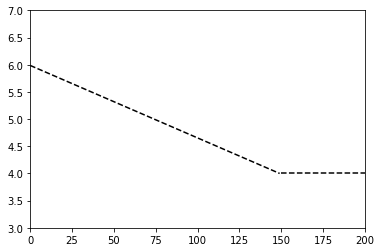

In [163]:
x = numpy.linspace(0,149,150)
y = numpy.zeros(len(x))
y[-1]= 10000
rate_at_x=numpy.zeros(len(x))
for i in range(len(rate_at_x)):
    rate_at_x[i] = growthr[ int(x[i]) ]

for i in range(len(x)-1):
    y[-i-2] = y[-i-1]*numpy.exp(rate_at_x[-i-1])
    
xx1 = [150,200]
yy1 = [10000,10000]
    
    
plt.plot(x,numpy.log(y)/numpy.log(10),'k--')
plt.plot(xx1,numpy.log(yy1)/numpy.log(10),'k--')


plt.ylim(3,7)
plt.xlim(0,200)


In [86]:
tcheck

[4.796379699760614,
 9.02510009899298,
 16.194418057982638,
 26.91908421399919,
 39.09656868650451,
 46.73460869600709,
 48.93887981275292,
 61.3716089618941,
 97.39936161918251,
 97.39936161918251,
 389.5029163763349,
 1083.5134606759186,
 9350.035875503403,
 17351.828108584763,
 -285021.50123252656]

In [51]:
sol

array([77.19248628, 20.96567292,  0.        ,  0.        ,  2.20324889,
        0.27914568,  0.59024402,  0.29476969,  0.6872213 ,  0.13355292,
       -0.7892277 ])

In [9]:
for i in range(len(PXmat)):
    print( numpy.sqrt(0.5*It_list[i] + 0.5*It_list[i+2] + It_list[i+1]) )

0.4873397172404482
0.9682458365518543
1.9364916731037085
3.872983346207417
7.745966692414834
15.491933384829668
30.983866769659336
61.96773353931867
123.93546707863734
409.3493898990736


In [73]:
for i in range(len(PXmat)):
    print( It_list[i+1])  

0.8
1.0
3.0
20.0
100.0
475.0
2400.0
12000.0
60000.0


In [76]:
for i in range(len(PXmat)):
    print( 10**(i/2)/2 )  

0.5
1.5811388300841898
5.0
15.811388300841896
50.0
158.11388300841898
500.0
1581.1388300841897
5000.0


In [79]:
51.2*5

256.0

In [81]:
51.2*5*5

1280.0

In [82]:
51.2*5*5*5

6400.0

In [83]:
51.2*5*5*5*5

32000.0

In [84]:
51.2*5*5*5*5*5

160000.0

In [14]:
changepoint = [*range(101)]
growthr = 0.1-numpy.array([*range(101)] )*0.001

pop_ini_size = 1411749
demo_model = msprime.Demography.isolated_model([pop_ini_size], growth_rate=[growthr[0]])
for i in range(1,len(changepoint)):
    demo_model.add_population_parameters_change(changepoint[i], initial_size=None, growth_rate=growthr[i], population=None)



In [15]:
demo_model

Demography(populations=[Population(initial_size=1411749.0, growth_rate=0.1, name='pop_0', description='', extra_metadata={}, default_sampling_time=None, initially_active=None, id=0)], events=[PopulationParametersChange(time=1, initial_size=None, growth_rate=0.099, population=-1), PopulationParametersChange(time=2, initial_size=None, growth_rate=0.098, population=-1), PopulationParametersChange(time=3, initial_size=None, growth_rate=0.097, population=-1), PopulationParametersChange(time=4, initial_size=None, growth_rate=0.096, population=-1), PopulationParametersChange(time=5, initial_size=None, growth_rate=0.095, population=-1), PopulationParametersChange(time=6, initial_size=None, growth_rate=0.094, population=-1), PopulationParametersChange(time=7, initial_size=None, growth_rate=0.093, population=-1), PopulationParametersChange(time=8, initial_size=None, growth_rate=0.092, population=-1), PopulationParametersChange(time=9, initial_size=None, growth_rate=0.091, population=-1), PopulationParametersChange(time=10, initial_size=None, growth_rate=0.09000000000000001, population=-1), PopulationParametersChange(time=11, initial_size=None, growth_rate=0.08900000000000001, population=-1), PopulationParametersChange(time=12, initial_size=None, growth_rate=0.08800000000000001, population=-1), PopulationParametersChange(time=13, initial_size=None, growth_rate=0.08700000000000001, population=-1), PopulationParametersChange(time=14, initial_size=None, growth_rate=0.08600000000000001, population=-1), PopulationParametersChange(time=15, initial_size=None, growth_rate=0.085, population=-1), PopulationParametersChange(time=16, initial_size=None, growth_rate=0.084, population=-1), PopulationParametersChange(time=17, initial_size=None, growth_rate=0.083, population=-1), PopulationParametersChange(time=18, initial_size=None, growth_rate=0.082, population=-1), PopulationParametersChange(time=19, initial_size=None, growth_rate=0.081, population=-1), PopulationParametersChange(time=20, initial_size=None, growth_rate=0.08, population=-1), PopulationParametersChange(time=21, initial_size=None, growth_rate=0.079, population=-1), PopulationParametersChange(time=22, initial_size=None, growth_rate=0.07800000000000001, population=-1), PopulationParametersChange(time=23, initial_size=None, growth_rate=0.07700000000000001, population=-1), PopulationParametersChange(time=24, initial_size=None, growth_rate=0.07600000000000001, population=-1), PopulationParametersChange(time=25, initial_size=None, growth_rate=0.07500000000000001, population=-1), PopulationParametersChange(time=26, initial_size=None, growth_rate=0.07400000000000001, population=-1), PopulationParametersChange(time=27, initial_size=None, growth_rate=0.07300000000000001, population=-1), PopulationParametersChange(time=28, initial_size=None, growth_rate=0.07200000000000001, population=-1), PopulationParametersChange(time=29, initial_size=None, growth_rate=0.07100000000000001, population=-1), PopulationParametersChange(time=30, initial_size=None, growth_rate=0.07, population=-1), PopulationParametersChange(time=31, initial_size=None, growth_rate=0.069, population=-1), PopulationParametersChange(time=32, initial_size=None, growth_rate=0.068, population=-1), PopulationParametersChange(time=33, initial_size=None, growth_rate=0.067, population=-1), PopulationParametersChange(time=34, initial_size=None, growth_rate=0.066, population=-1), PopulationParametersChange(time=35, initial_size=None, growth_rate=0.065, population=-1), PopulationParametersChange(time=36, initial_size=None, growth_rate=0.064, population=-1), PopulationParametersChange(time=37, initial_size=None, growth_rate=0.063, population=-1), PopulationParametersChange(time=38, initial_size=None, growth_rate=0.062000000000000006, population=-1), PopulationParametersChange(time=39, initial_size=None, growth_rate=0.061000000000000006, population=-1), PopulationParametersChange(time=40, initial_size=None, growth_rate=0.060000000000000005, populati

In [16]:
changepoint

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100]

In [17]:
growthr

array([0.1  , 0.099, 0.098, 0.097, 0.096, 0.095, 0.094, 0.093, 0.092,
       0.091, 0.09 , 0.089, 0.088, 0.087, 0.086, 0.085, 0.084, 0.083,
       0.082, 0.081, 0.08 , 0.079, 0.078, 0.077, 0.076, 0.075, 0.074,
       0.073, 0.072, 0.071, 0.07 , 0.069, 0.068, 0.067, 0.066, 0.065,
       0.064, 0.063, 0.062, 0.061, 0.06 , 0.059, 0.058, 0.057, 0.056,
       0.055, 0.054, 0.053, 0.052, 0.051, 0.05 , 0.049, 0.048, 0.047,
       0.046, 0.045, 0.044, 0.043, 0.042, 0.041, 0.04 , 0.039, 0.038,
       0.037, 0.036, 0.035, 0.034, 0.033, 0.032, 0.031, 0.03 , 0.029,
       0.028, 0.027, 0.026, 0.025, 0.024, 0.023, 0.022, 0.021, 0.02 ,
       0.019, 0.018, 0.017, 0.016, 0.015, 0.014, 0.013, 0.012, 0.011,
       0.01 , 0.009, 0.008, 0.007, 0.006, 0.005, 0.004, 0.003, 0.002,
       0.001, 0.   ])

In [ ]:
Ntlist

In [43]:
###### 有用 ， 找X2 快一点 ### 代替 tree 那个循环，到 while 结束后两行

    mu_time = mts.tables.mutations.time
    mu_site_id = mts.tables.mutations.site
    mu_site = mts.tables.sites.position[mu_site_id]
    mu_node = mts.tables.mutations.node
    mufreq = numpy.zeros(len(mu_time))
    rate_nomu = numpy.zeros( (len(seq_bp)-1)*(2*sam_size-1) )
    rate_mu = numpy.zeros( (len(seq_bp)-1)*(2*sam_size-1) )
    timevec_all = numpy.zeros( (len(seq_bp)-1)*(2*sam_size-1) )
    current_rate_nomu = numpy.zeros(2*sam_size-1)
    freqtime = mu_time 
    
    mu_index = 0
    for tree in mts.trees():
        for each_mu in tree.mutations():
            mufreq[mu_index] = tree.num_samples(each_mu.node)
            mu_index = mu_index+1


            
    for i in range(2*sam_size-1):
        current_time = mts.diversity(sample_sets=[[i,i+1]],windows=seq_bp,mode='branch',span_normalise=False).flatten()/2
        current_rate_nomu = current_time*(seq_bp[1:]- seq_bp[0:(len(seq_bp)-1)])*2
        timevec_all[ (i*(len(seq_bp)-1)):((i+1)*(len(seq_bp)-1))  ] = current_time
        rate_nomu[ (i*(len(seq_bp)-1)):((i+1)*(len(seq_bp)-1)) ] =current_rate_nomu
        rate_mu[ (i*(len(seq_bp)-1)):((i+1)*(len(seq_bp)-1)) ] = current_rate_nomu*mu_in_interval
        
        if i % 10 ==1:
            print(i)
        
            
            


1
11
21
31
41
51
61
71


KeyboardInterrupt: 

In [ ]:
    sortindex = numpy.argsort(rate_mu)
    rate_mu_sort = rate_mu[sortindex]
    timevec_all_sort = timevec_all[sortindex]

In [32]:
timevec_all_sort1 = numpy.array(timevec_all_sort)
rate_mu_sort1=numpy.array(rate_mu_sort)

In [34]:
len(timevec_all_sort)

19990

In [36]:
mu_in_interval

array([1.00162028e-08, 9.92447675e-09, 1.00374365e-08, 9.99120103e-09,
       1.00099194e-08, 9.97307805e-09, 1.00341765e-08, 9.93799304e-09,
       9.93461196e-09, 1.01447333e-08])

In [35]:
seq_bp

array([0.00000000e+00, 9.98382342e+06, 2.00599214e+07, 3.00226245e+07,
       4.00314313e+07, 5.00215217e+07, 6.00485163e+07, 7.00144562e+07,
       8.00768500e+07, 9.01426685e+07, 1.00000000e+08])

In [41]:
mts.diversity(sample_sets= [[i,i+1]], windows=seq_bp, mode='branch', span_normalise=False).flatten()

array([2.02297240e+12, 2.05328227e+12, 2.03014534e+12, 2.08226101e+12,
       1.81633339e+12, 2.03085435e+12, 1.91359365e+12, 2.03992344e+12,
       2.00771724e+12, 1.80163635e+12])

In [38]:
i

98

In [99]:
tcheck

[13.758171700857496,
 20.05974590290411,
 26.391336210876783,
 33.83169787896554,
 42.585919201105426,
 47.89767505038172,
 48.2226136989075,
 57.30477061280491,
 89.03804353787976,
 133.07214917087902,
 313.97062722585963,
 996.2969648277757,
 4176.104830763975,
 17911.75682180125,
 86695.56234478696]

In [132]:
for i in range(len(PXmat)):
    print(  It_list[i+1]**2 )  


0.04000000000000001
0.16000000000000003
0.6400000000000001
2.5600000000000005
10.240000000000002
40.96000000000001
163.84000000000003
655.3600000000001
5446.44
225625.0
5760000.0
144000000.0
3600000000.0


In [138]:
for i in range(len(PXmat)):
    print(  It_list[i+2]**2 )

0.16000000000000003
0.6400000000000001
2.5600000000000005
10.240000000000002
40.96000000000001
163.84000000000003
655.3600000000001
5446.44
225625.0
5760000.0
144000000.0
3600000000.0
2503247300689.6743


In [136]:
for i in range(len(PXmat)):
    print(  It_list[i+1]**2 )

0.04000000000000001
0.16000000000000003
0.6400000000000001
2.5600000000000005
10.240000000000002
40.96000000000001
163.84000000000003
655.3600000000001
5446.44
225625.0
5760000.0
144000000.0
3600000000.0


In [154]:
    tildetcheck = [0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6,51.2,102.4,512,2560,12800,64000]

In [30]:
for i in range(len(PXmat)):
    print(numpy.sqrt(0.5*It_list[i] + 0.5*It_list[i+2] + It_list[i+1]) )

0.4873397172404482
0.9682458365518543
1.9364916731037085
3.872983346207417
7.745966692414834
15.482247898803326
11.97914855071094
23.80126047082381
62.35783832045495
124.74694385034049
366.8312875284586


In [28]:
for i in range(len(PXmat)):
    print(It_list[i+1]**2)

0.0056250000000000015
0.09000000000000002
1.4400000000000004
23.040000000000006
368.6400000000001
5898.240000000002
94003.56000000001
162409.0
2664729.7600000002
24159191.040000007
386547056.6400001


In [35]:
3.87/1.93

2.005181347150259

In [26]:
1.34/0.94

1.4255319148936172

In [27]:
1/1.4/2

0.35714285714285715

In [30]:
0.25/2**6

0.00390625

In [35]:
2.5/1.89

1.3227513227513228

In [7]:
1/3**6

0.0013717421124828531

In [8]:
1/2.8**6

0.002075161072342307

(0.0, 50.0)

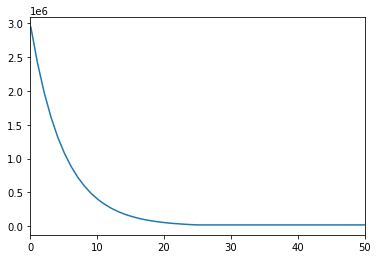

In [10]:
import statistics
import msprime
from IPython.display import SVG, display
import tsinfer
import scipy
import math
import numpy
import tskit
import io
import builtins
import sys
from tqdm.notebook import tqdm
from tskit import MISSING_DATA
import pickle
import random
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.linear_model import LassoLarsIC
import matplotlib.pyplot as plt
import cvxopt as opt
from cvxopt import matrix, spmatrix, sparse
from cvxopt.solvers import qp, options
from cvxopt import blas
from cvxopt import spdiag
import statsmodels
from statsmodels.nonparametric.kernel_regression import KernelReg
from scipy.signal import savgol_filter
import bisect

def find_s_s(elem, sorted_list):
    'Locate the leftmost value smaller or equal to x'
    i = bisect.bisect_left(sorted_list, elem)
    if i != 0:
        return i
    else:
        return 0
    
def ISE(x_points, invest,Nt, model):
    ISE = 0
    for i in range(len(x_points)-1):
        true_y = model[1][  min(find_s_s(x_points[i],model[0]),len(model[1])-1 ) ]
        est_y = Nt[  min(find_s_s(x_points[i], invest),len(Nt)-1 ) ]
        ISE = ISE + (x_points[i+1]-x_points[i])*(true_y-est_y)**2 
    return(ISE)




x1 = numpy.linspace(0.1,200,200)
x2 = numpy.linspace(205,50000,500)
x = numpy.array(x1.tolist()+x2.tolist())

y = numpy.zeros(len(x))

for i in range(len(x)):
    if x[i] <= 25:
        y[i] = 1500000*2*numpy.exp(-0.2*x[i])
    else:
        y[i] = 1500000*2*numpy.exp(-0.2*25)

M8 = [numpy.array(x),numpy.array(y)]
plt.plot(M8[0],M8[1])
plt.xlim(0,50)

In [11]:




model = M8

name = "Model8_lam5_Ntlist_approach12.dat"
file = open(name,"rb") 
Ntlist = pickle.load(file)
file.close()

name = "Model8_lam5_investlist__approach12.dat"
file = open(name,"rb") 
investlist = pickle.load(file)
file.close()

ISE_list = []
x_points = numpy.linspace(0,50,100)

for i in range(len(Ntlist)):
    tpoint = [0]
    Npoint = []
    for j in range(len(investlist[i])):
        if j % 2 == 1:
            tpoint.append(investlist[i][j])
    for j in range(len(Ntlist[i])):
        if j % 2 == 1:
            Npoint.append(Ntlist[i][j])

    pxpoint = [0] 
    pypoint = [Npoint[0]]
    for j in range(len(tpoint)-1):
        pxpoint.append( (tpoint[j] + tpoint[j+1])/2 )
        pypoint.append( Npoint[j] )

    xp_dense = numpy.arange(0,max(pxpoint))
    yp_dense = numpy.arange(0,max(pxpoint))
    
    for k in range(1,len(xp_dense)-1):
        ind = find_s_s(xp_dense[k],pxpoint)
        firstx = pxpoint[ind-1]
        secondx = pxpoint[ind]
        firsty = pypoint[ind-1]
        secondy = pypoint[ind]
        yp_dense[k] = firsty + (secondy-firsty)/(secondx-firstx)*(xp_dense[k]-firstx)
        
        
    investlist[i] = xp_dense
    Ntlist[i] = yp_dense
    
    
num=0
for i in range(len(Ntlist)):
    num=num+1
    invest=investlist[i]
    Nt = Ntlist[i]
    ISE_list.append(ISE(x_points, invest,Nt, model))

MISE = sum(numpy.array(ISE_list))/num
RMISE = numpy.sqrt(MISE)
CI = numpy.sqrt(  (numpy.sort(ISE_list)[numpy.array([0,-1])] - MISE)/numpy.sqrt(num) + MISE   )

print("RMISE", numpy.round(RMISE/10**5,2))
print("CI", numpy.round(CI/10**5,2))

    

RMISE 69.0
CI [63.1  90.89]


/tmp/ipykernel_210390/2576180624.py:1: RuntimeWarning: divide by zero encountered in log
  plt.plot(investlist[0],numpy.log(Ntlist[0])/numpy.log(10) )


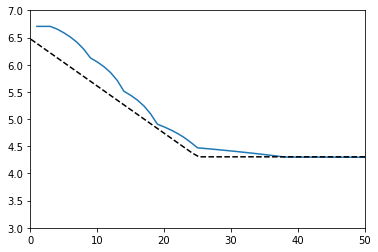

In [26]:
plt.plot(investlist[0],numpy.log(Ntlist[0])/numpy.log(10) )

plt.ylim(3,7)
plt.xlim(0,50)

x1 = numpy.linspace(0.1,200,200)
x2 = numpy.linspace(205,50000,500)
x = numpy.array(x1.tolist()+x2.tolist())

y = numpy.zeros(len(x))

for i in range(len(x)):
    if x[i] <= 25:
        y[i] = 1500000*2*numpy.exp(-0.2*x[i])
    else:
        y[i] = 1500000*2*numpy.exp(-0.2*25)

        
plt.plot(x,numpy.log(y)/numpy.log(10),'k--')

In [ ]:
lam 5       rmise 65.48     bic  3300 3800 3900 2700 
lam=10 最好 rmise 70.78   bic: 3100 3800 4500 3500
lam=20  rmise 70.97   bic: 3400 3800 3900 3500
